In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import pandas as pd

# Конфигурация
DATA_DIR = Path("data")
NUM_CLASSES = 18
CHARACTERS = {
    0: "Ace", 1: "Akainu", 2: "Brook", 3: "Chopper", 4: "Crocodile",
    5: "Franky", 6: "Jinbei", 7: "Kurohige", 8: "Law", 9: "Luffy",
    10: "Mihawk", 11: "Nami", 12: "Rayleigh", 13: "Robin", 14: "Sanji",
    15: "Shanks", 16: "Usopp", 17: "Zoro"
}
# Обратный маппинг: имя персонажа -> номер класса
CHARACTER_TO_ID = {name: idx for idx, name in CHARACTERS.items()}
BATCH_SIZE = 16 
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
IMG_SIZE = 224

if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print(f"Устройство: {DEVICE}")
print(f"PyTorch версия: {torch.__version__}")
if DEVICE == "mps":
    print("  Используется Apple Silicon (MPS)")


Устройство: mps
PyTorch версия: 2.5.1
  Используется Apple Silicon (MPS)


## Dataset и трансформации


In [ ]:
class OnePieceDataset(Dataset):
    def __init__(self, data_dir, transform=None, is_test=False):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.is_test = is_test
        self.images = []
        self.labels = []
        self._load_data()
    
    def _load_data(self):
        if not self.data_dir.exists():
            raise ValueError(f"Директория {self.data_dir} не существует")
        
        if self.is_test:
            for img_path in (list(self.data_dir.glob("*.jpg")) + 
                           list(self.data_dir.glob("*.png")) + 
                           list(self.data_dir.glob("*.jpeg"))):
                self.images.append(str(img_path))
                self.labels.append(-1) 
            return
        
        if (self.data_dir / "0").exists():
            for class_id in range(NUM_CLASSES):
                class_dir = self.data_dir / str(class_id)
                if class_dir.exists():
                    for img_path in (list(class_dir.glob("*.jpg")) + 
                                   list(class_dir.glob("*.png")) + 
                                   list(class_dir.glob("*.jpeg"))):
                        self.images.append(str(img_path))
                        self.labels.append(class_id)
            return
        
        found_classes = False
        for class_name, class_id in CHARACTER_TO_ID.items():
            class_dir = self.data_dir / class_name
            if class_dir.exists() and class_dir.is_dir():
                found_classes = True
                for img_path in (list(class_dir.glob("*.jpg")) + 
                               list(class_dir.glob("*.png")) + 
                               list(class_dir.glob("*.jpeg"))):
                    self.images.append(str(img_path))
                    self.labels.append(class_id)
        
        if found_classes:
            return
        
        for subdir in self.data_dir.iterdir():
            if not subdir.is_dir():
                continue
            
            if (subdir / "0").exists():
                for class_id in range(NUM_CLASSES):
                    class_dir = subdir / str(class_id)
                    if class_dir.exists():
                        for img_path in (list(class_dir.glob("*.jpg")) + 
                                       list(class_dir.glob("*.png")) + 
                                       list(class_dir.glob("*.jpeg"))):
                            self.images.append(str(img_path))
                            self.labels.append(class_id)
                return
            
            found_in_subdir = False
            for class_name, class_id in CHARACTER_TO_ID.items():
                class_dir = subdir / class_name
                if class_dir.exists() and class_dir.is_dir():
                    found_in_subdir = True
                    for img_path in (list(class_dir.glob("*.jpg")) + 
                                   list(class_dir.glob("*.png")) + 
                                   list(class_dir.glob("*.jpeg"))):
                        self.images.append(str(img_path))
                        self.labels.append(class_id)
            
            if found_in_subdir:
                return
        
        if len(self.images) == 0:
            raise ValueError(f"Не найдены изображения в {self.data_dir}. Проверьте структуру данных.")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            if isinstance(self.transform, A.Compose):
                image = np.array(image)
                image = self.transform(image=image)['image']
            else:
                image = self.transform(image)
        
        return image, label

def get_transforms(is_train=True):
    if is_train:
        return A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

print("Dataset и трансформации определены!")


Dataset и трансформации определены!


## Модель


In [ ]:
def get_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(512, NUM_CLASSES)
    )
    return model

model = get_model().to(DEVICE)
print(f"Модель создана: Параметров: {sum(p.numel() for p in model.parameters()):,}")


Модель создана: Параметров: 11,185,746


## Загрузка данных


In [ ]:
train_path = None

if (DATA_DIR / "splitted" / "train").exists():
    splitted_train = DATA_DIR / "splitted" / "train"
    if any((splitted_train / name).exists() for name in CHARACTER_TO_ID.keys()) or (splitted_train / "0").exists():
        train_path = splitted_train

if train_path is None and (DATA_DIR / "train").exists():
    if (DATA_DIR / "train" / "0").exists() or any((DATA_DIR / "train" / name).exists() for name in CHARACTER_TO_ID.keys()):
        train_path = DATA_DIR / "train"

if train_path is None and (DATA_DIR / "0").exists():
    train_path = DATA_DIR

if train_path is None:
    for subdir in DATA_DIR.iterdir():
        if not subdir.is_dir():
            continue
        if (subdir / "0").exists():
            train_path = subdir
            break
        if any((subdir / name).exists() for name in CHARACTER_TO_ID.keys()):
            train_path = subdir
            break

if train_path is None:
    raise ValueError(f"Не найдены данные в {DATA_DIR}.")

print(f"Используем данные из: {train_path}")

train_dataset = OnePieceDataset(train_path, transform=get_transforms(is_train=True))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_path = None
if (DATA_DIR / "splitted" / "val").exists():
    splitted_val = DATA_DIR / "splitted" / "val"
    if (splitted_val / "0").exists() or any((splitted_val / name).exists() for name in CHARACTER_TO_ID.keys()):
        val_path = splitted_val
if val_path is None and (DATA_DIR / "val").exists():
    if (DATA_DIR / "val" / "0").exists() or any((DATA_DIR / "val" / name).exists() for name in CHARACTER_TO_ID.keys()):
        val_path = DATA_DIR / "val"

if val_path:
    val_dataset = OnePieceDataset(val_path, transform=get_transforms(is_train=False))
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print(f"Тренировочный набор: {len(train_dataset)} изображений")
    print(f"Валидационный набор: {len(val_dataset)} изображений")
else:
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    indices = torch.randperm(len(train_dataset)).tolist()
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    val_dataset_no_aug = OnePieceDataset(train_path, transform=get_transforms(is_train=False))
    val_subset = torch.utils.data.Subset(val_dataset_no_aug, val_indices)
    
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print(f"Тренировочный набор: {train_size} изображений")
    print(f"Валидационный набор: {val_size} изображений (из train)")

class_counts = Counter(train_dataset.labels)
print(f"\nРаспределение классов:")
for class_id, count in sorted(class_counts.items()):
    print(f"  {CHARACTERS[class_id]}: {count} изображений")


Используем данные из: data/splitted/train
Тренировочный набор: 2332 изображений
Валидационный набор: 583 изображений (из train)

Распределение классов:
  Ace: 168 изображений
  Akainu: 167 изображений
  Brook: 178 изображений
  Chopper: 170 изображений
  Crocodile: 167 изображений
  Franky: 170 изображений
  Jinbei: 166 изображений
  Kurohige: 170 изображений
  Law: 175 изображений
  Luffy: 97 изображений
  Mihawk: 167 изображений
  Nami: 181 изображений
  Rayleigh: 167 изображений
  Robin: 167 изображений
  Sanji: 135 изображений
  Shanks: 168 изображений
  Usopp: 170 изображений
  Zoro: 132 изображений


## Функции обучения и валидации


In [11]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    
    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    return running_loss / len(loader), accuracy_score(all_labels, all_preds)

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / len(loader), accuracy_score(all_labels, all_preds)

print("Функции обучения определены!")


Функции обучения определены!


## Обучение модели


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print(f"\nНачало обучения на {NUM_EPOCHS} эпох...")
print(f"Batch size: {BATCH_SIZE}, Устройство: {DEVICE}")
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} ({epoch_time:.1f}s): Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"  Сохранена лучшая модель (Val Acc: {val_acc:.4f})")

total_time = time.time() - start_time
print(f"\nОбучение завершено за {total_time/60:.1f} минут! Лучшая точность: {best_val_acc:.4f}")



Начало обучения на 10 эпох...
Batch size: 16, Устройство: mps


Training:   7%|▋         | 10/146 [00:04<00:51,  2.66it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  38%|███▊      | 14/37 [00:02<00:03,  6.85it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.97it/s]


Epoch 1/10 (67.4s): Train Loss: 0.3116, Train Acc: 0.9074, Val Loss: 0.8371, Val Acc: 0.7907
  Сохранена лучшая модель (Val Acc: 0.7907)


Training:   7%|▋         | 10/146 [00:03<00:51,  2.67it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  38%|███▊      | 14/37 [00:02<00:03,  6.57it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.68it/s]


Epoch 2/10 (66.7s): Train Loss: 0.2606, Train Acc: 0.9305, Val Loss: 0.8009, Val Acc: 0.7890


Training:   8%|▊         | 11/146 [00:04<00:56,  2.40it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  38%|███▊      | 14/37 [00:02<00:03,  6.72it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 37/37 [00:06<00:00,  6.03it/s]


Epoch 3/10 (67.7s): Train Loss: 0.2534, Train Acc: 0.9224, Val Loss: 0.6499, Val Acc: 0.8285
  Сохранена лучшая модель (Val Acc: 0.8285)


Training:   3%|▎         | 5/146 [00:02<00:57,  2.45it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  38%|███▊      | 14/37 [00:02<00:03,  6.46it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.63it/s]


Epoch 4/10 (67.2s): Train Loss: 0.1719, Train Acc: 0.9554, Val Loss: 0.8261, Val Acc: 0.8045


Training:  23%|██▎       | 33/146 [00:13<00:51,  2.21it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  38%|███▊      | 14/37 [00:02<00:03,  6.43it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.65it/s]


Epoch 5/10 (68.5s): Train Loss: 0.1869, Train Acc: 0.9477, Val Loss: 0.9396, Val Acc: 0.7856


Training:   1%|▏         | 2/146 [00:00<00:53,  2.71it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  38%|███▊      | 14/37 [00:02<00:03,  5.95it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.59it/s]


Epoch 6/10 (68.2s): Train Loss: 0.2070, Train Acc: 0.9357, Val Loss: 1.0460, Val Acc: 0.7667


Training:   3%|▎         | 4/146 [00:01<00:57,  2.46it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  38%|███▊      | 14/37 [00:02<00:03,  6.28it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.34it/s]


Epoch 7/10 (69.5s): Train Loss: 0.1430, Train Acc: 0.9563, Val Loss: 0.7167, Val Acc: 0.8250


Training:  12%|█▏        | 17/146 [00:08<01:05,  1.97it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  38%|███▊      | 14/37 [00:02<00:03,  6.44it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.54it/s]


Epoch 8/10 (70.3s): Train Loss: 0.0389, Train Acc: 0.9893, Val Loss: 0.4891, Val Acc: 0.8731
  Сохранена лучшая модель (Val Acc: 0.8731)


Training:   5%|▌         | 8/146 [00:03<01:03,  2.18it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  38%|███▊      | 14/37 [00:02<00:04,  5.62it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.48it/s]


Epoch 9/10 (74.1s): Train Loss: 0.0271, Train Acc: 0.9919, Val Loss: 0.5056, Val Acc: 0.8714


Training:  14%|█▍        | 21/146 [00:10<01:03,  1.96it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  38%|███▊      | 14/37 [00:02<00:03,  6.70it/s]/opt/homebrew/Caskroom/miniconda/base/envs/one-piece-classification/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.86it/s]


Epoch 10/10 (74.1s): Train Loss: 0.0160, Train Acc: 0.9983, Val Loss: 0.4611, Val Acc: 0.8799
  Сохранена лучшая модель (Val Acc: 0.8799)

Обучение завершено за 11.6 минут! Лучшая точность: 0.8799


## Визуализация истории обучения


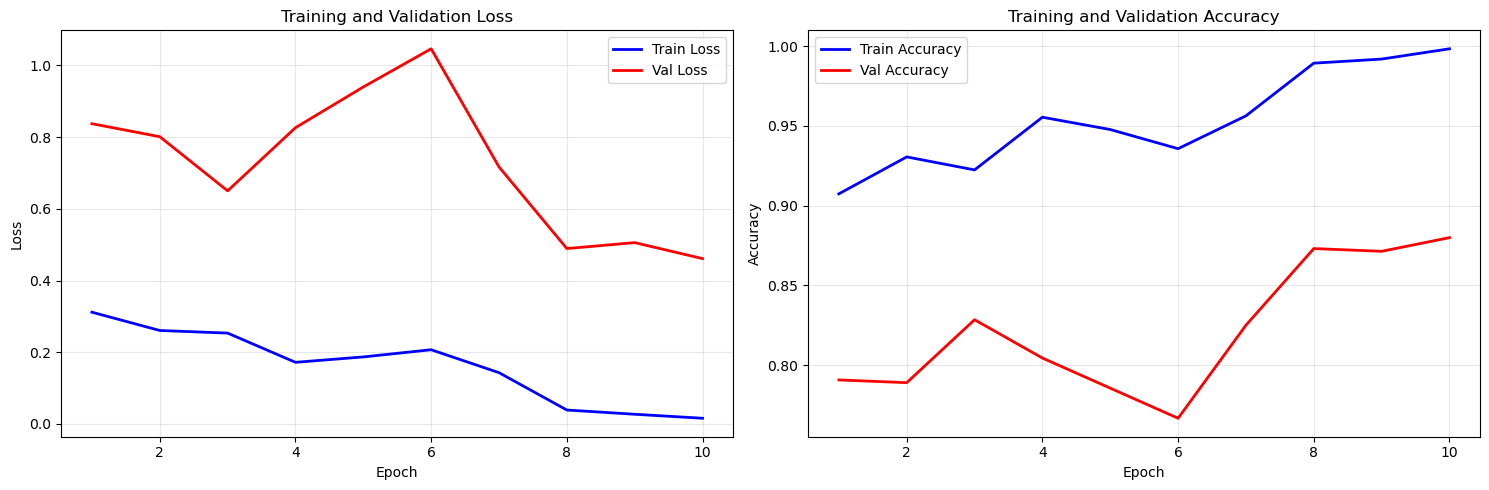

График сохранен: training_history.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("График сохранен: training_history.png")


## Оценка на тестовом наборе


In [ ]:
test_path = None
if (DATA_DIR / "splitted" / "test").exists():
    test_path = DATA_DIR / "splitted" / "test"
elif (DATA_DIR / "test").exists():
    if (DATA_DIR / "test" / "0").exists() or any((DATA_DIR / "test" / name).exists() for name in CHARACTER_TO_ID.keys()):
        test_path = DATA_DIR / "test"
    elif len(list((DATA_DIR / "test").glob("*.jpg")) + list((DATA_DIR / "test").glob("*.png"))) > 0:
        test_path = DATA_DIR / "test"

if test_path:
    has_subdirs = any((test_path / name).exists() and (test_path / name).is_dir() 
                      for name in list(CHARACTER_TO_ID.keys()) + ["0"])
    
    if has_subdirs:
        print("Тестовый набор с метками классов")
        model.load_state_dict(torch.load("best_model.pth"))
        test_dataset = OnePieceDataset(test_path, transform=get_transforms(is_train=False))
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        
        all_preds, all_labels = [], []
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc='Testing'):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_acc = accuracy_score(all_labels, all_preds)
        print(f"\nTest Accuracy: {test_acc:.4f}")
        
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[CHARACTERS[i] for i in range(NUM_CLASSES)],
                   yticklabels=[CHARACTERS[i] for i in range(NUM_CLASSES)])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Confusion matrix сохранена: confusion_matrix.png")
        
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, 
                                    target_names=[CHARACTERS[i] for i in range(NUM_CLASSES)]))
    else:
        print("Тестовый набор без меток (только предсказания)")
        
        model.load_state_dict(torch.load("best_model.pth"))
        model.eval()
        
        test_dataset = OnePieceDataset(test_path, transform=get_transforms(is_train=False), is_test=True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        
        all_preds = []
        
        with torch.no_grad():
            for images, _ in tqdm(test_loader, desc='Predicting'):
                images = images.to(DEVICE)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy().tolist())
        
        all_ids = [Path(img_path).stem for img_path in test_dataset.images]
        
        assert len(all_ids) == len(all_preds), f"Несоответствие: {len(all_ids)} файлов, {len(all_preds)} предсказаний"
        
        submission_df = pd.DataFrame({
            'id': all_ids,
            'label': all_preds
        })
        
        submission_file = 'submission.csv'
        submission_df.to_csv(submission_file, index=False)
        print(f"\n  Submission файл сохранен: {submission_file}")
        print(f"  Всего предсказаний: {len(all_preds)}")
        print(f"\nПервые 10 строк:")
        print(submission_df.head(10))
        
        # Проверяем распределение предсказаний
        pred_counts = Counter(all_preds)
        print(f"\nРаспределение предсказанных классов:")
        for class_id, count in sorted(pred_counts.items()):
            print(f"  {CHARACTERS[class_id]}: {count} изображений")
else:
    print("Тестовый набор не найден.")


Найден тестовый набор: data/splitted/test
Тестовый набор без меток (только предсказания)
Генерируем submission файл...


/var/folders/75/nm4slt554bz9c_hph0z5k4q80000gn/T/ipykernel_68938/569444129.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.


  Submission файл сохранен: submission.csv
  Всего предсказаний: 849

Первые 10 строк:
                                     id  label
0  c76dff28-137e-439e-b8d4-8ded5cf1f176     17
1  c1e33526-2645-444a-9694-1cb671393a8a      0
2  9b9aa5d8-1df1-412c-867e-f477207e848c      0
3  ea47a640-c1ab-4997-96dd-0cdc5b952c0d     14
4  10971537-a0a3-44f7-9690-daa910277dca     14
5  053800a1-8a78-4a55-9aaa-015d6dcf94c8      9
6  98317974-eb1d-4d30-80c5-66f570faa4b6     17
7  aae55a43-445a-4a4e-97cb-9e977a2cc36b      9
8  795cdd77-e1ab-4514-b047-d2c439fbdb23     17
9  73802718-867a-4810-8f45-3480a55c78a8      9

Распределение предсказанных классов:
  Ace: 54 изображений
  Akainu: 49 изображений
  Brook: 46 изображений
  Chopper: 45 изображений
  Crocodile: 48 изображений
  Franky: 61 изображений
  Jinbei: 46 изображений
  Kurohige: 46 изображений
  Law: 38 изображений
  Luffy: 30 изображений
  Mihawk: 52 изображений
  Nami: 54 изображений
  Rayleigh: 54 изображений
  Robin: 48 изображений
  Sanji: 4